<a href="https://colab.research.google.com/github/ClementBM/Experiment_DeepLearning_Moonboard_Grade-Prediction/blob/master/LSTM_BoulderProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import some relevant packages

In [1]:
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

from climbing_ai.moonboard_dataset import MoonboardDataset, data_preprocessing, extract_batch
from climbing_ai.moonboard_tokenizer import MoonboardTokenizer
from climbing_ai.moonboard_evaluation import evaluate
from climbing_ai.lstm_simple import LSTMModel

N_LAYERS = 3
DROPOUT = 0.1
EMBED_DIM = 60

IGNORE_INDEX = -100

EVAL_ITERS = 10
MAX_ITERS = 10000
EVAL_INTERVAL = 1000
LEARNING_RATE = 1e-3
EPOCHS = 300

BATCH_SIZE = 64 # how many independent sequences will we process in parallel?

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and parse data
I scrapped little bits of data from the moonboard official website (hoped they don't bother.. ). The data is formatted as json files. Each file is named with the grade difficulty. In this step, I also calculate the distance between holds.

In [2]:
dataset = data_preprocessing()
shuffled_dataset = shuffle(dataset, random_state=42)

max_len = max([len(data["holds"]) for data in dataset]) + 2

# Keep 90% for training, 10% for validation
split = int(0.9 * len(dataset))

train_ds = shuffled_dataset[:split]
eval_ds = shuffled_dataset[split:]

tokenizer = MoonboardTokenizer(
    horizontal_count=11,
    vertical_count=18,
    horizontal_spacing=50,
    vertical_spacing=50,
)

train_dataset = MoonboardDataset(
    dataset=train_ds, tokenizer=tokenizer, max_len=max_len
)
eval_dataset = MoonboardDataset(
    dataset=eval_ds, tokenizer=tokenizer, max_len=max_len
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

# Look at the data
Just a brief look at the data. We have distances - numerical data - and hold names - categorical data. In the following parts we use the one-hot vectors created from hold names. We add the numerical to the one-hot vector, ugly method waiting for a way to combine numerical and categorical variables in neural network.

In [3]:
eval_dataset[9]

{'input_ids': tensor([  0,  72, 101, 112, 114, 140, 189, 200, 201, 201, 201, 201, 201, 201,
         201, 201]),
 'input_locations': tensor([[-100, -100],
         [ 150,  850],
         [ 250,  500],
         [-100, -100],
         [ 300,  250],
         [ 350,  650],
         [ 500,  400],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100]]),
 'masked_input_ids': tensor([  0,  72, 101, 199, 114, 140, 189, 200, 201, 201, 201, 201, 201, 201,
         201, 201]),
 'masked_token_ids': tensor([ 112, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100]),
 'masked_positions': tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 'sequence_length': tensor(8),
 'grade_id': tensor(10)}

# Building the model
Here we define the LSTM RNN

```python
model.add(Activation("linear"))
model.compile(loss='mae', optimizer='adam')
```

In [4]:
model = LSTMModel(input_dim=tokenizer.get_vocab_size(),
                  hidden_dim=EMBED_DIM,
                  layer_dim=N_LAYERS,
                  output_dim=len(MoonboardDataset.grades),
                  embedding_dim=EMBED_DIM,
                  max_len=max_len).to(DEVICE)

# Loss function
loss_fn_lm = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)


In [5]:
epoch_iterator = tqdm(range(EPOCHS))
model.train()

for epoch in epoch_iterator:
    for batch in train_dataloader:
        optimizer.zero_grad()

        (
            input_ids,
            input_locations,
            masked_input_ids,
            masked_token_ids,
            masked_positions,
            attention_mask,
            grade_id,
            sequence_length,
        ) = extract_batch(batch, DEVICE)

        outputs = model(input_ids, sequence_length)
        loss = loss_fn_lm(outputs, grade_id)

        epoch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
        
        loss.backward()
        optimizer.step()

100%|██████████| 600/600 [02:01<00:00,  4.92it/s, loss=0.015]


# Evaluate
* We make predictions on the test set rounding the predicted grade floating number.
* We then calculate the related MAE based on these prediction.
* The grade error is shown in the heat map.
* The absolute error is shown in the histogram.

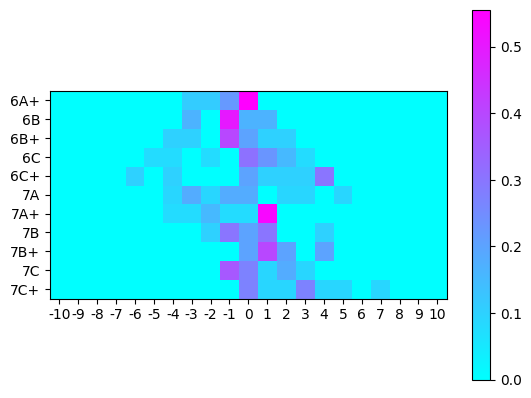

MAE = 1.6513761281967163
Correctness Count = {0} : [23.85%] + {1} : [35.78%] = 59.63%
First Bound Grade Error Count = {2} : [13.76%] + {3} : [11.93%] = 25.69%
Second Bound Grade Error Count = {4} : [10.09%] + {5} : [2.75%] + {6} : [0.92%] = 13.76%


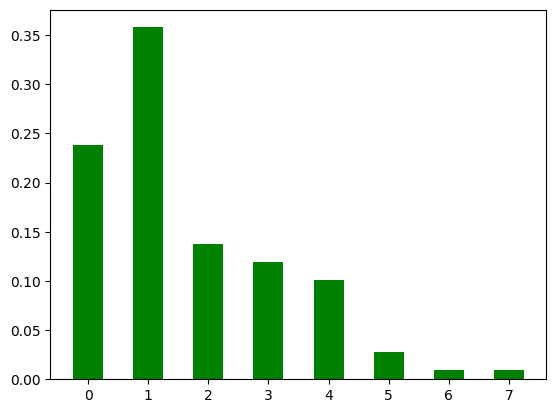

In [6]:
def call_model(compressed_batch, model):
    (
        input_ids,
        input_locations,
        masked_input_ids,
        masked_token_ids,
        masked_positions,
        attention_mask,
        grade_id,
        sequence_length,
    ) = compressed_batch

    logits_clsf = model(input_ids, sequence_length)
    return logits_clsf

evaluate(model=model,
         call_model=call_model,
         dataloader=eval_dataloader,
         device=DEVICE)